In [1]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [2]:
sys.path.insert(1, '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# sys.path.insert(1, '/extra/stefan/utils/scrnaseq_utils/')
from scrnaseq_util_functions import *
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'

In [3]:
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'

h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
for k in ['exampledataset', 'NormanWeissman2019_raw']:
    if k in h5_files.keys(): del h5_files[k]
for k in ['PapalexiSatija2021_eccite_arrayed_protein', 'PapalexiSatija2021_eccite_protein', 'FrangiehIzar2021_protein']:
    if k in h5_files.keys(): del h5_files[k]
for k in ['gene_scores', 'ChromVar', 'LSI_embedding', 'markerpeak_target', 'peak_bc']:
    if k in h5_files.keys(): del h5_files[k]

print(len(h5_files))
list(h5_files.keys())

35


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'GehringPachter2019',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWeissman2016_GSM2406675_10X001',
 'SrivatsanTrapnell2020_sciplex2

# Denser Submatrix

Chris: Maybe sparsity in the count matrix biases the pca and leads to higher sigma. We could select genes and cell such that we have less zeros left and then try computing PCA and then pca distances (sigma/delta).

In [40]:
# get distances
key = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(f"/fast/scratch/users/peidlis_c/perturbation_resource_paper/tmp_data_{key}.h5")
adata.shape

(4200, 15987)

In [41]:
density = adata.X.nnz / np.multiply(*adata.shape)
print(f'Percentage of nonzero entries in GEX matrix: {np.round(density*100,1)}%')

Percentage of nonzero entries in GEX matrix: 21.0%


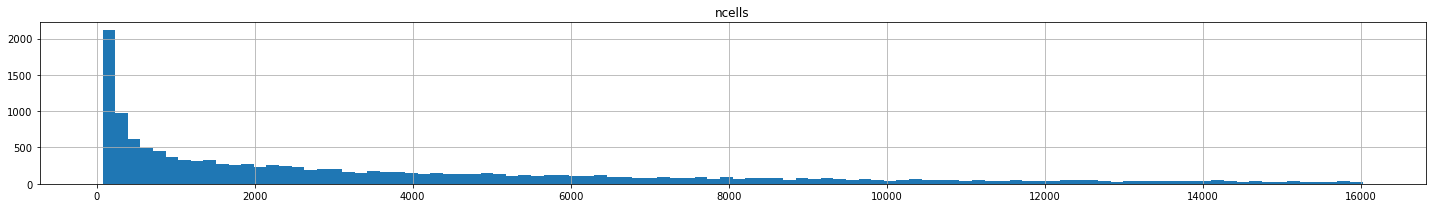

In [42]:
var_hist(adata, 'ncells')

In [43]:
cutoff = 2000
subdata = adata[:, adata.var.ncells>=cutoff].copy()
density = subdata.X.nnz / np.multiply(*subdata.shape)
print(f'Percentage of nonzero entries in GEX matrix after subsetting: {np.round(density*100,1)}%')

Percentage of nonzero entries in GEX matrix after subsetting: 37.4%


This is bad: if a perturbation induces a gene's expression specifically and it is 0 otherwise, we will lose this gene... This makes computing deltas between perturbations with this pointless.

# How to select descriptive features

Core idea: For scRNA-seq from primary tissue we select HVGs as feature selection. Genes that are quite specific for a celltype will be in there probably. This makes less sense in the case of perturbations and cell lines because
- lots of variation will be noise
- we know which differences to expect: we can select features that discriminate the perturbations from each other and/or control

Also see https://scikit-learn.org/stable/modules/feature_selection.html:

>Feature selection with sparse data
>
>If you use sparse data (i.e. data represented as sparse matrices), chi2, mutual_info_regression, mutual_info_classif will deal with the data without making it dense.

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_regression

X = adata.layers['counts']
y = adata.obs.perturbation

In [49]:
selector = SelectKBest(chi2, k=2000)
selector.fit(X, y)
selected = [int(x[1:]) for x in selector.get_feature_names_out()]
var_selected = adata.var_names[np.array(selected)]

In [50]:
sc.pp.highly_variable_genes(adata, layer='counts', n_top_genes=2000, flavor='seurat_v3')
hvg_selected = adata.var[adata.var.highly_variable].index

In [60]:
from matplotlib_venn import venn2

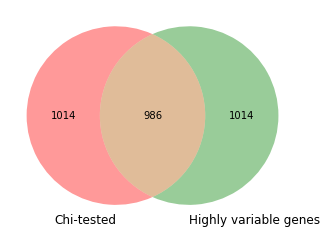

In [64]:
venn2((set(var_selected), set(hvg_selected)), ['Chi-tested', 'Highly variable genes']);

In [66]:
subdata = adata[:, var_selected].copy()
sc.pp.pca(subdata, use_highly_variable=False)
sc.pp.neighbors(subdata)
sc.tl.umap(subdata)

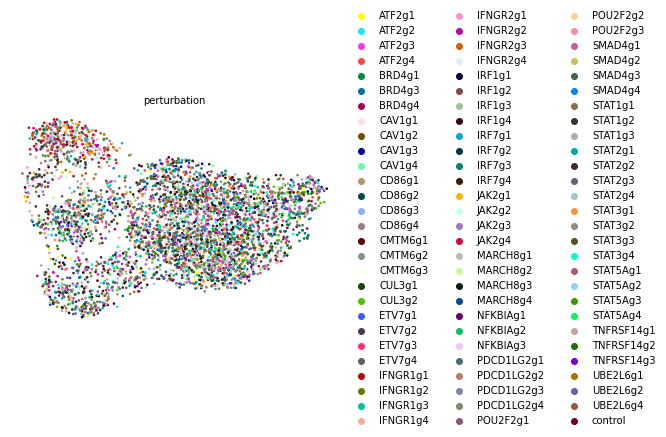

In [71]:
scv.pl.scatter(subdata, color='perturbation', legend_loc='right margin')

In [76]:
df = pairwise_pca_distances(subdata, 'perturbation')

100%|██████████| 84/84 [00:29<00:00,  2.89it/s]


<AxesSubplot:>

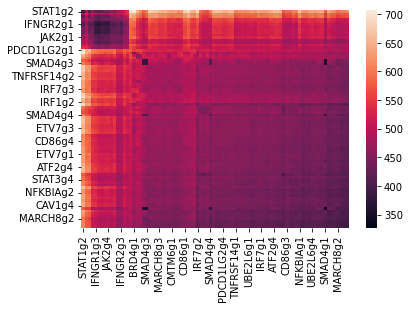

In [79]:
df_clustered = cluster_matrix(df, 'both')
sns.heatmap(df_clustered)

In [68]:
subdata_ = adata[:, hvg_selected].copy()
sc.pp.pca(subdata_, use_highly_variable=False)
sc.pp.neighbors(subdata_)
sc.tl.umap(subdata_)

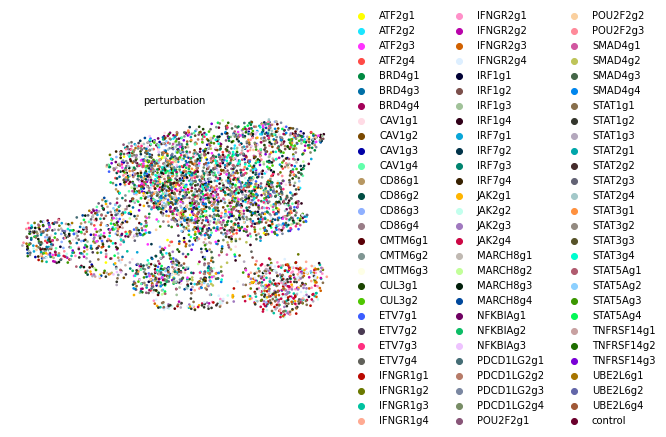

In [73]:
scv.pl.scatter(subdata_, color='perturbation', legend_loc='right margin')

In [80]:
df_ = pairwise_pca_distances(subdata_, 'perturbation')

100%|██████████| 84/84 [00:28<00:00,  2.92it/s]


<AxesSubplot:>

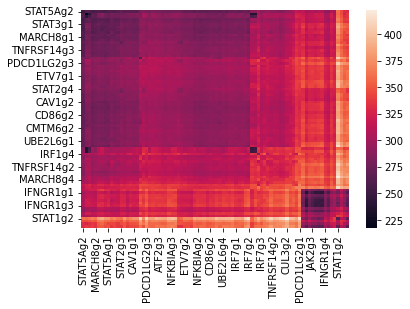

In [81]:
df_clustered_ = cluster_matrix(df_, 'both')
sns.heatmap(df_clustered_)